# DS 3000 - Project Phase 4

## Forecasting Commercial Airline Flight Status Using Basic Climate Variables

**Team Members**: Yuge Xue, Jason Pereira, Hongkang Xu, Maxim Turkowski

**Date**: 2021/12/09

## 1. Overview

### 1a. Introduction

Modern societies are characterized by a high degree of geographical mobility, brought by the
development and diversification of transport systems. This growing demand for mobility
relies heavily on transport systems. As shown throughout the Covid-19 pandemic, restricted
access to key transport systems can significantly impact price levels.

One sector, which regularly experiences delays, is the air traffic sector. Between 2004 and
2017, roughly 22% of all flights within the United States were either cancelled or delayed
([The Bureau of Transport, 2018](https://www.transtats.bts.gov/)). Forbes estimated that every minute delayed results in an
average reduction of USD 1.42 in delayed flight ticket prices ([Luttman, 2019](https://www.sciencedirect.com/science/article/abs/pii/S2212012218300042?via%3Dihub)). Obviously,
delays are also inconvenient when it comes to keeping appointments or flying with travel
plans.

Adverse weather conditions are an important external factor affecting delays in the air traffic
system, accounting for up to 50 percent of all delayed flights pre-Covid19 ([Federal Aviation
Administration, 2017](https://www.faa.gov/nextgen/programs/weather/)). With the world economy (and air traffic system) in gradual recovery,
2
more flights will again become affected under adverse weather conditions. The ability to
forecast these onset events are crucial to reducing costs and improving efficiency.

### 1b. Defining The Problem

Based on our abstract above, the main focus of our project is provide answers the following questions:
1. Are there existing correlations between climate variables and time-matching flight
status of significance?
2. How can we effectively utilize derived trends to forecast future flight travel status
based on forecasted climate variables?


### 1c. Motivation

Our motivation for picking this topic stems from personal experiences with flights being
unexpectedly cancelled or delayed. Nothing feels worse than finishing finals and all you can
think about is enjoying a break with your friends and family and travel complications start
you off on the wrong foot. It has happened multiple times where we have gone to Logan
Airport on a snowy day, gone through all the hassle of passing through security, sitting at the
gate, and sometimes boarding the flight just for it to get delayed or cancelled due to weather
conditions. These experiences have motivated us to see if we can predict whether or not a
flight will be delayed or cancelled just based on that day's weather report.

## 2. Data Acquisition

### 2a. Introduction

Our initial plan was to acquire both airport data and weather data from major API providers such as AviationStack, OpenWeatherMap, etc. However, we quickly realized the drawbacks of those APIs:
1. Most APIs do not provide historical flight data that allows us to build our model
2. Most major weather API providers do not provide relative weather conditions at airports. The provided data were not applicable for aviation usage.
3. Most APIs do not provide free or reasonable price for the scale of our project
4. Some APIs take long time for queries, which significantly slow our progress.

We did further researches and quickly found two data sources that fit our purpose and available for us to use:
1. Boston Logan Airport data: [Bureau of Transportation Statistics](https://www.transtats.bts.gov/ONTIME/)
2. Local Climatological Data: [National Centers for Environmental Information](https://www.ncei.noaa.gov/products/land-based-station/local-climatological-data)

The BTS data provides on-time statistics that details the delays of each flight. Since our plan was to determine the correlation between climate variables and flight delays, we would need to gather the departure dataset since weather factors would most likely impact planes that are on-ground. Furthermore, the aviation industry has taken its worst impact last year due to the COVID-19 pandemic, which resulted a relatively small size of dataset in 2020 available for us to use. Therefore, we pulled five airlines (Jetblue, American, United, JetBlue, Spirit) departure data from Logan Airport in 2019, and combined then into one single file.

The Local Climatological Data provides insights on historical professional aviation weather reports. We were able to examine multiple factors such as wind/gust speeds, precip, visibility and temperature at Logan Airport. We pulled the 2019 data which contains weather reports for roughly every five minutes.

### 2b. Setting up

Python libraries used in this project: pandas, numpy, matplotlib, seaborn, sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn import metrics

sns.set()

In [2]:
KBOS_flights = "data/KBOS_Jetblue_United_American_Spirit_2019.csv"
KBOS_weather = "data/Weather.csv"

flights_df = pd.read_csv(KBOS_flights)
weather_df = pd.read_csv(KBOS_weather)

### 2c. Data Preview

Flight Data: Merged dataset combining five major airline flights departing Logan airport in 2019

In [3]:
# the merged dataset combining five airlines departing Logan airport in 2019
flights_df.head()

,Carrier,Date,Flight,Tail,Destination,Scheduled_departure,Actual_departure,Schedule_elapsed,Actual_elapsed,Departure_delay,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,B6,01/01/2019,19,N945JB,SAN,16:18,16:09,399,374,-9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B6,01/01/2019,21,N351JB,PBI,11:19,11:12,209,210,-7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B6,01/01/2019,49,N621JB,SAV,06:24,08:33,169,176,129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B6,01/01/2019,51,N994JB,MCO,05:35,05:29,200,209,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B6,01/01/2019,55,N229JB,DCA,07:11,06:59,108,119,-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Weather Data: Dataset containing climate variables recorded in Weather Station USW00014739 nearest to Logan aiport in 2019, updated every 5 minutes

In [4]:
# the weather report at Logan airport in 2019, with entries separated by roughly five minutes
weather_df.head()

,STATION,DATE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,...,HourlySkyConditions,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM,REPORT_TYPE,SOURCE
0,72509014739,2019-01-01T00:07:00,29.94,37.0,39,0.04,RA:02 BR:1 |RA |RA,NaN,NaN,93.0,...,SCT:04 8 OVC:08 41,29.91,3.00,38.0,130,NaN,17.0,MET10601/01/19 00:07:02 SPECI KBOS 010507Z 130...,FM-16,7
1,72509014739,2019-01-01T00:24:00,29.93,37.0,40,0.08,RA:02 BR:1 |RA |RA,NaN,NaN,89.0,...,FEW:02 8 BKN:07 13 OVC:08 22,29.90,4.00,39.0,140,NaN,16.0,MET11301/01/19 00:24:02 SPECI KBOS 010524Z 140...,FM-16,7
2,72509014739,2019-01-01T00:54:00,29.89,38.0,40,0.14,-RA:02 BR:1 |RA |RA,0.19,8.0,93.0,...,FEW:02 8 BKN:07 13 OVC:08 21,29.86,5.00,39.0,150,NaN,13.0,MET14501/01/19 00:54:02 METAR KBOS 010554Z 150...,FM-15,7
3,72509014739,2019-01-01T01:00:00,NaN,38.0,40,NaN,||RA,0.19,8.0,93.0,...,8,29.87,4.97,39.0,150,NaN,13.0,SYN09872509 11358 81511 10044 20033 30114 4012...,FM-12,4
4,72509014739,2019-01-01T01:54:00,29.80,39.0,42,0.09,-RA:02 BR:1 |RA |RA,NaN,NaN,89.0,...,OVC:08 12,29.77,5.00,41.0,120,NaN,9.0,MET10701/01/19 01:54:02 METAR KBOS 010654Z 120...,FM-15,7


## 3. Data Preperation

### 3a. Initial Data Cleaning

We start by dropping empty columns

In [5]:
# drop all columns with all NaN values
flights_df.dropna(axis=1, how='all', inplace=True)
weather_df.dropna(axis=1, how='all', inplace=True)

### 3b. Data Cleaning for Flights Dataframe

In [6]:
# merge date and time in flights, since we only care about departure time
flights_df["Date"] = flights_df["Date"] + " " + flights_df["Scheduled_departure"]

# since we only care about weather delays, we only need flight departure time and weather delay info
flights_df = flights_df[['Carrier', 'Date', 'Delay_weather']]

# rename date column
flights_df.rename({'Date': 'Time'}, axis=1, inplace=True)

# convert time column to datetime objects
flights_df['Time'] = pd.to_datetime(flights_df['Time'])

Data processing results for flights dataframe

In [7]:
flights_df.head()

,Carrier,Time,Delay_weather
0,B6,2019-01-01 16:18:00,0
1,B6,2019-01-01 11:19:00,0
2,B6,2019-01-01 06:24:00,0
3,B6,2019-01-01 05:35:00,0
4,B6,2019-01-01 07:11:00,0


In [8]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98508 entries, 0 to 98507
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Carrier        98508 non-null  object        
 1   Time           98508 non-null  datetime64[ns]
 2   Delay_weather  98508 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.3+ MB


### 3c. Data Cleaning for Weather Dataframe

For weather factors, we used [this article](https://www.getservice.com/blog/why-is-my-flight-delayed/) to determine the weather factors that could result in flight delays. 

**METAR: Aviation Routine Weather Report, encoded messages for pilots' use**

In [9]:
# select the factors that directly result to flight delays
weather_df = weather_df[['DATE', 
                         'HourlyDewPointTemperature', 
                         'HourlyPrecipitation', 
                         'HourlyVisibility', 
                         'HourlyWindGustSpeed', 
                         'HourlyWindSpeed']]

# Interestingly, we found string 'T' in the HourlyPrecipitation column
# as indicated by the NOAA, 'T' stands for trace precipitation amount
# which indicates less than 0.01 inch of rain.
# we simply replace those Ts with 0s
mapping = {'T': 0}
weather_df.HourlyPrecipitation = [mapping[precip] if precip in mapping.keys() else precip
                                  for precip in weather_df.HourlyPrecipitation]

# we found 's' in HourlyPrecipitation column in form like '0.06s'
# 's' indicates snow according to weather.gov
# we simply drop the s
weather_df.HourlyPrecipitation = [precip[:-1] if type(precip) == str and precip[-1] == 's' else precip
                                  for precip in weather_df.HourlyPrecipitation]

# similar step being performed on HourVisibility
weather_df.HourlyVisibility = [vis[:-1] if type(vis) == str and vis[-1] == 'V' else vis
                                  for vis in weather_df.HourlyVisibility]


# we filter out all entries recorded on 23:59 everyday, as
# those only contain METAR messages
format = '%Y-%m-%dT%H:%M:%S'
weather_df['Time'] = pd.to_datetime(weather_df['DATE'], format=format)
weather_df.set_index(pd.DatetimeIndex(weather_df['Time']), inplace=True)
del weather_df['DATE']
del weather_df['Time']
weather_df = weather_df.between_time('0:00', '23:58')


# since wind gusts does not persist, the column may contain 
# NaN values as the indication of no wind gusts, we replace 
# NaN entries to 0s in this column
weather_df['HourlyWindGustSpeed'] = weather_df['HourlyWindGustSpeed'].replace(np.nan, 0)


# we observed there are still a decent amount of entries
# contain NaN values. We forward fill those fields since
# the usual gap between entries are five minutes, which
# the time gap can result minimal impact on weather changes
weather_df.fillna(method='ffill', inplace=True)

Data processing results for weather dataframe

In [10]:
weather_df.head()

,HourlyDewPointTemperature,HourlyPrecipitation,HourlyVisibility,HourlyWindGustSpeed,HourlyWindSpeed
Time,,,,,
2019-01-01 00:07:00,37.0,0.04,3.00,0.0,17.0
2019-01-01 00:24:00,37.0,0.08,4.00,0.0,16.0
2019-01-01 00:54:00,38.0,0.14,5.00,0.0,13.0
2019-01-01 01:00:00,38.0,0.14,4.97,0.0,13.0
2019-01-01 01:54:00,39.0,0.09,5.00,0.0,9.0
...,...,...,...,...,...
2019-12-31 21:06:00,33.0,0.00,10.00,0.0,9.0
2019-12-31 21:54:00,33.0,0.00,10.00,0.0,10.0
2019-12-31 22:00:00,33.0,0.00,9.94,0.0,10.0


In [11]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13713 entries, 2019-01-01 00:07:00 to 2019-12-31 23:54:00
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HourlyDewPointTemperature  13713 non-null  float64
 1   HourlyPrecipitation        13713 non-null  object 
 2   HourlyVisibility           13713 non-null  object 
 3   HourlyWindGustSpeed        13713 non-null  float64
 4   HourlyWindSpeed            13713 non-null  float64
dtypes: float64(3), object(2)
memory usage: 642.8+ KB


For weather factors, we used [this article](https://www.getservice.com/blog/why-is-my-flight-delayed/) to determine the weather factors that could result in flight delays. 

**METAR: Aviation Routine Weather Report, encoded messages for pilots' use

### 3d. Merging Weather Dataframe with Flights Dataframe

Merge the two dataframes based on nearest time data

In [12]:
# First set the index to the Time column on flights dataset
flights_df.set_index('Time', inplace=True)

# Drop unwanted duplicates in weather dataset
weather_df = weather_df[~weather_df.index.duplicated(keep='first')]

# Attach the weather info to flights
# We match flight's time data to the closest weather timestamp
attached_df = weather_df.reindex(flights_df.index, method='nearest')
processed_df = pd.concat([attached_df, flights_df], axis=1)
processed_df.head()

,HourlyDewPointTemperature,HourlyPrecipitation,HourlyVisibility,HourlyWindGustSpeed,HourlyWindSpeed,Carrier,Delay_weather
Time,,,,,,,
2019-01-01 16:18:00,29.0,0.00,9.94,0.0,23.0,B6,0
2019-01-01 11:19:00,44.0,0.00,10.00,31.0,22.0,B6,0
2019-01-01 06:24:00,48.0,0,10.00,0.0,15.0,B6,0
2019-01-01 05:35:00,46.0,0.01,10.00,0.0,10.0,B6,0
2019-01-01 07:11:00,48.0,0.00,10.00,0.0,18.0,B6,0


## 4. Data Modeling and Machine Learning

### 4a. Model Selection

During phase 3, we decided to use the K nearest neighbor model due to its simple, intuitive, and non-parametric algorithm. We look to evaluate different K values to retrieve acceptable accuracy score. 

In addition to phase 3, we are also looking to use Random Forest Classifier. Since our target consists categorical features (on-time vs delayed), we can first test the accuracy of the model predicting flight status categorically (on-time vs delayed) and then again numerically (duration of delay).

We will be splitting 70% of the data for training and 30% of the data for testing.

### 4b. Data Classification

We initially tried to separate the delayed flights to sub-categories such as 'under 30 miuntes delays', 'more than 1 hour delays', etc. However, the models are predicting at minimal levels for those sub-categories. Thus, we only split them between on-time vs delayed for the models

In [13]:
# for classification, we separate flights from on-time and delayed
def classify_delay(entry):
    if entry['Delay_weather'] == 0:
        return 'On-Time'
    return 'Delayed'

processed_df['Status'] = processed_df.apply(classify_delay, axis=1)
processed_df.head()

,HourlyDewPointTemperature,HourlyPrecipitation,HourlyVisibility,HourlyWindGustSpeed,HourlyWindSpeed,Carrier,Delay_weather,Status
Time,,,,,,,,
2019-01-01 16:18:00,29.0,0.00,9.94,0.0,23.0,B6,0,On-Time
2019-01-01 11:19:00,44.0,0.00,10.00,31.0,22.0,B6,0,On-Time
2019-01-01 06:24:00,48.0,0,10.00,0.0,15.0,B6,0,On-Time
2019-01-01 05:35:00,46.0,0.01,10.00,0.0,10.0,B6,0,On-Time
2019-01-01 07:11:00,48.0,0.00,10.00,0.0,18.0,B6,0,On-Time


The below correlation pairplot shows that most climate variables are dependent of each other, despite noticable linear correlations between Hourly Wind Gust Speed and Hourly Wind Speed. According to the guide on Basic Climate Variables mentioned above, such variables are still a necessary inclusion.

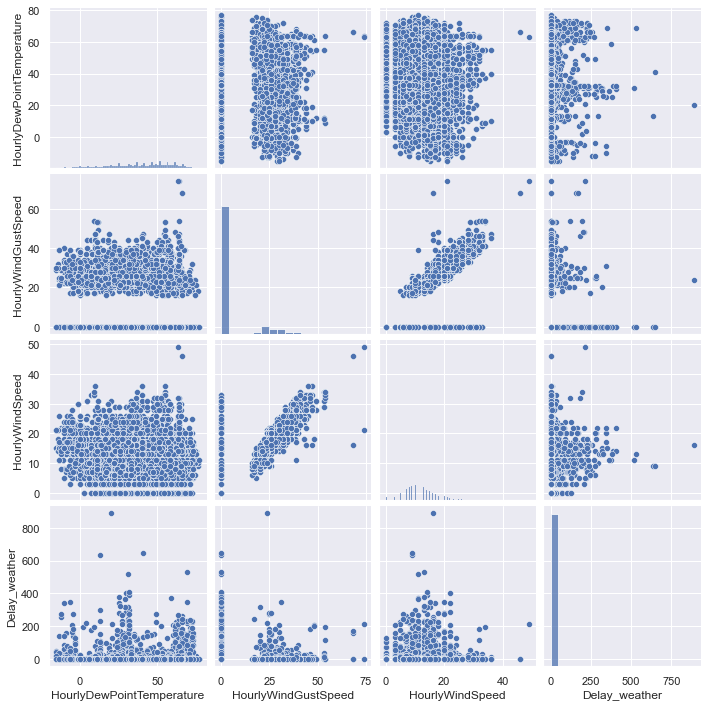

In [14]:
# we use pairplot to directly visualize the correlations between the features
g = sns.pairplot(processed_df)
plt.show()

### 4c. (Categorical) Data Model Training using the K-Nearest Neighbor Model

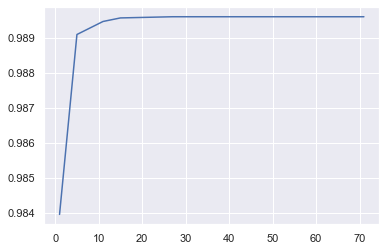

In [15]:
# we now partition the data into train/test split
X = processed_df[['HourlyDewPointTemperature', 
                    'HourlyPrecipitation', 
                    'HourlyVisibility', 
                    'HourlyWindGustSpeed', 
                    'HourlyWindSpeed']]
y = processed_df['Status']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=7,
                                                    stratify=y
                                                   )

#build the k-nn model, we experiment with different values of k and plot the results
predictions = {}

for k in (1, 5, 11, 15, 27, 34, 42, 49, 53, 67, 71):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    predictions[k] = knn.score(X_test, y_test)

sns.lineplot(x=predictions.keys(), y=predictions.values())
plt.show()

In [16]:
# we will take k=5 to better analyze our results
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)
y_pred = knn_5.predict(X_test)

feat_list = ['Delayed', 'On-Time']
feat_list.sort()
print(classification_report(y_test, y_pred, target_names=feat_list))

              precision    recall  f1-score   support

     Delayed       0.33      0.05      0.09       307
     On-Time       0.99      1.00      0.99     29246

    accuracy                           0.99     29553
   macro avg       0.66      0.52      0.54     29553
weighted avg       0.98      0.99      0.99     29553



The KNN model as seen above with n=5 is giving us very high predictions. However, closer examination reveals that the predictions are highly accurate for on-time flights, with relatively low performance on delayed flights. We believe there two major factors contributing to this result:

1. The population of the delayed flights in our dataset is relatively too low comparing to on-time flights
2. The records of those weather delayed flights from BTS does not specify if the delay is the result of the arrival airports rather than the Logan airport

### 4d. (Numeric) Data Model Training using the Random Forest Classifier

In [17]:
# partition the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# score the accuracy of our prediction
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9878523330964708


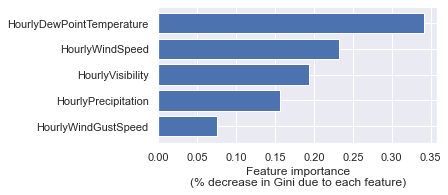

In [18]:
# Feature importances
x_feat_list = ['HourlyDewPointTemperature', 
                'HourlyPrecipitation', 
                'HourlyVisibility', 
                'HourlyWindGustSpeed', 
                'HourlyWindSpeed']

def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(% decrease in Gini due to each feature)')
    
plot_feat_import(x_feat_list, clf.feature_importances_)

From the feature importances, we can tell that dew point temperature is likely the most dominant feature in predicting the flights, while gust speed is relatively low in importance.

Again, the models are highly acurate on predicting categorical flight status. For the duration of delayed flights, we might need a much larger sample of data to train the models, preferrably spanning across a long period of time and involving flight data from more airline companies.

## 5. Conclusion

We believe these the two trained models used in this project (KNN and Random Forest Regressor) can be applied to our everyday lives. They demonstrate the possibilities of predicting on-time flights based on basic climate variables. The accuracy of these two models show, respectively, that they can accurately predict flight status (on time/ delayed) but may struggle to predict an accurate amount of the duration delayed. Nevertheless, this project offers a perspective into using statistical models to predicting air travel flight status given basic climate variables, which might be useful for travellers planning their flight schedule. With more people catching their flight on time, we can expect the recurring loss of additional economic resources in air traffic to considerably reduce.